In [1]:
#Put the path to HSequences here:
#Download url is http://icvl.ee.ic.ac.uk/vbalnt/hpatches/hpatches-sequences-release.tar.gz
dn = '/home/old-ufo/Dropbox/HP/'


In [2]:
import torch
import torch.nn
import numpy as np
import seaborn as sns
from Losses import distance_matrix_vector,distance_vectors_pairwise, get_snn
from ReprojectionStuff import get_GT_correspondence_indexes
from SparseImgRepresenter import ScaleSpaceAffinePatchExtractor
#%matplotlib inline
import seaborn as sns
#plt.imshow(255 - img1.cpu().data.numpy()[0,0,:,:])
from LAF import visualize_LAFs
#LOP.out_lafs1['HardNet'][0][0]
from LAF import bsvd2x2,getLAFelongation,getNumCollapsed
def loss_HardNegC(anchor, positive, margin = 1.0):
    assert anchor.size() == positive.size(), "Input sizes between positive and negative must be equal."
    assert anchor.dim() == 2, "Inputd must be a 2D matrix."
    eps = 1e-8
    dist_matrix_detach = distance_matrix_vector(anchor, positive.detach()) + eps
    pos1 = distance_vectors_pairwise(anchor,positive)
    eye = torch.autograd.Variable(torch.eye(dist_matrix_detach.size(1))).cuda()
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag = dist_matrix_detach + eye*10
    mask = (dist_without_min_on_diag.ge(0.08).float()-1)*-1
    mask = mask.type_as(dist_without_min_on_diag)*10
    dist_without_min_on_diag = dist_without_min_on_diag + mask
    min_neg = torch.min(dist_without_min_on_diag,1)[0]
    #loss = 0.5 * torch.mean(loss)
    dist_matrix_detach2 = distance_matrix_vector(anchor.detach(), positive) + eps
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag2 = dist_matrix_detach2 + eye*10
    mask2 = (dist_without_min_on_diag2.ge(0.08).float()-1)*-1
    mask2 = mask2.type_as(dist_without_min_on_diag2)*10
    dist_without_min_on_diag2 = dist_without_min_on_diag2 + mask2
    min_neg2 = torch.min(dist_without_min_on_diag2,0)[0]
    #min_neg_all = torch.min(min_neg.view(-1),min_neg2.view(-1))
    #print min_neg_all.shape
    loss = torch.clamp(margin + pos1 - 0.5*(min_neg2 + min_neg), min=0.0).mean()
    return loss

In [3]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import os
from Utils import batched_forward
from PIL import Image
from LAF import denormalizeLAFs, LAFs2ell, abc2A
from HardNet import HardNet
from LAF import extract_patches, normalizeLAFs,convertLAFs_to_A23format,LAF2pts 
from LAF import LAFs2ell,abc2A, angles2A, generate_patch_grid_from_normalized_LAFs
from LAF import extract_patches, get_inverted_pyr_index,get_pyramid_and_level_index_for_LAFs
from HandCraftedModules import ScalePyramid
from LAF import denormalizeLAFs, extract_patches_from_pyramid_with_inv_index, rectifyAffineTransformationUpIsUp
import math
from copy import deepcopy
import gc
def get_input_param_optimizer(x, lr):
    input_param = nn.Parameter(x.data)
    optimizer = optim.Adam([input_param], lr=lr)
    return input_param, optimizer

def visualize_LAFs_on_fig(ax, LAFs, color = 'r'):
    work_LAFs = convertLAFs_to_A23format(LAFs)
    lines = {}
    for i in range(len(work_LAFs)):
        ell = LAF2pts(work_LAFs[i,:,:])
        lines[str(i)], = ax.plot( ell[:,0], ell[:,1], color)
    return lines, ax
def getScale(A):
    return torch.sqrt(torch.abs(A[:,0,0] * A[:,1,1] - A[:,0,1]*A[:,1,0]) + 1e-12)
def FrobNorm(a1,a2, norm_scale = True):
    if norm_scale:
        sc1 = getScale(a1)
        sc2 = getScale(a2)
        min_sc = 0.5 * (sc1 + sc2)
        a1 = a1 / min_sc.view(-1,1,1).expand_as(a1)
        a2 = a2 / min_sc.view(-1,1,1).expand_as(a2)
    return torch.sqrt(((a1 - a2)**2).view(a1.size(0),-1).sum(dim=1)+1e-12).mean()
class LAFDiscrOptimDetach():
    def __init__(self, descriptors_list, names_list, loss_fn = loss_HardNegC, cuda = False, lr = 1e-0,
                loss_name = 'HardNegC'):
        assert len(descriptors_list) == len(names_list)
        self.desc_list = descriptors_list
        self.names_list = names_list
        self.colors = ['r', 'g', 'b', 'y', 'm', 'k', 'c']
        self.cuda = cuda
        self.out_lafs1 = {}
        self.out_lafs2 = {}
        self.loss_func = loss_fn
        self.loss_name = loss_name;
        self.save_dir = self.loss_name + '_saves_ideal'
        self.out_loss_mean = {}
        self.cent_diff = {}
        self.shape_diff = {}
        self.snn = {}
        self.lr = lr;
        for dn in names_list:
            self.out_lafs1[dn] = []
            self.out_lafs2[dn] = []      
            self.out_loss_mean[dn] =[]
            self.cent_diff[dn] = []
            self.shape_diff[dn] =[]
            self.snn[dn] =[]
        self.ScalePyrGen = ScalePyramid(nLevels = 1, init_sigma = 1.6, border = 32)
        return
    def extract_patches_from_pyr(self, dLAFs, scale_pyr, sigmas, pix_dists, PS = 32):
        pyr_idxs, level_idxs = get_pyramid_and_level_index_for_LAFs(dLAFs, sigmas, pix_dists, PS)
        pyr_inv_idxs = get_inverted_pyr_index(scale_pyr, pyr_idxs, level_idxs)
        patches = extract_patches_from_pyramid_with_inv_index(scale_pyr,
                                                      pyr_inv_idxs,
                                                      normalizeLAFs(dLAFs, scale_pyr[0][0].size(3),
                                                                    scale_pyr[0][0].size(2)), 
                                                      PS = PS)
        return patches
    def optimize(self, laf1, laf2, img1, img2, n_iters = 10):
        if self.cuda:
            img1,img2 = img1.cuda(),img2.cuda()
        w1,h1 = img1.size(3),img1.size(2)
        w2,h2 = img2.size(3),img2.size(2)
        self.scale_pyr1, self.sigmas1, self.pix_dists1 = self.ScalePyrGen(img1)
        self.scale_pyr2, self.sigmas2, self.pix_dists2 = self.ScalePyrGen(img2)
        
        for d_idx in range(len(self.names_list)):
            D = self.desc_list[d_idx]
            try:
                if self.cuda:
                    D = D.cuda()
            except:
                pass
            N = self.names_list[d_idx]
            print N
            l1 = deepcopy(Variable(deepcopy(laf1)))
            l2 = deepcopy(Variable(deepcopy(laf2)))
            if self.cuda:
                l1 = l1.cuda()
                l2 = l2.cuda()
            l1o, opt1 = get_input_param_optimizer(l1[:,:2,:2], self.lr)
            l2o, opt2 = get_input_param_optimizer(l2[:,:2,:2], self.lr)
            self.out_lafs1[N].append(deepcopy(torch.cat([l1o.data, l1.data[:,:,2:]], dim = 2).cpu()))
            self.out_lafs2[N].append(deepcopy(torch.cat([l2o.data, l2.data[:,:,2:]], dim = 2).cpu()))
            self.shape_diff[N].append(deepcopy(FrobNorm(deepcopy(l1o.detach()),deepcopy(l2o.detach()))))
            for it in range(n_iters):
                #p1 = extract_patches(img1, normalizeLAFs(torch.cat([l1o, l1[:,:,2:]],dim = 2), w1, h1));
                p1 = self.extract_patches_from_pyr(torch.cat([l1o, l1[:,:,2:]],dim = 2),
                                                   self.scale_pyr1,
                                                   self.sigmas1,
                                                   self.pix_dists1, PS = 32)
                desc1 = batched_forward(D,p1, 32)
                p2 = self.extract_patches_from_pyr(torch.cat([l1o, l1[:,:,2:]],dim = 2),
                                                   self.scale_pyr2,
                                                   self.sigmas2,
                                                   self.pix_dists2, PS = 32)
                #p2 = extract_patches(img2, normalizeLAFs(torch.cat([l2o, l2[:,:,2:]],dim = 2), w2, h2));
                desc2 = batched_forward(D,p2, 32)
                loss = self.loss_func(desc1,desc2)
                if it % 10 == 0:
                    print loss.data.cpu().numpy()
                opt1.zero_grad()
                opt2.zero_grad()
                loss.backward() 
                opt1.step()
                opt2.step()
                self.out_lafs1[N].append(deepcopy(torch.cat([l1o.data, l1.data[:,:,2:]], dim = 2).cpu()))
                self.out_lafs2[N].append(deepcopy(torch.cat([l1o.data, l1.data[:,:,2:]], dim = 2).cpu()))
                self.out_loss_mean[N].append(deepcopy(loss.data.mean()))
                self.cent_diff[N].append(0)#deepcopy(torch.sqrt(((l1o.data[:,:,2] - l2o.data[:,:,2])**2).sum(dim=1)+1e-12).mean()))
                self.shape_diff[N].append(deepcopy(FrobNorm(deepcopy(l1o.detach()),deepcopy(l1o.detach()))))
                with torch.no_grad():
                    self.snn[N].append(deepcopy(get_snn(desc1,desc2).cpu().view(1,-1)))
            del l1,l2,opt1,opt2
            gc.collect()
            torch.cuda.empty_cache()
        self.img1 = img1.data.cpu().numpy()
        self.img2 = img2.data.cpu().numpy()
        return
    def save_data(self, fname):
        data_dict = {'LAFs1':self.out_lafs1, 'LAFs2':self.out_lafs2, 'loss_mean': self.out_loss_mean,
                    'cent_diff': self.cent_diff, 'shape_diff': self.shape_diff, 'snn': self.snn}
        if not os.path.isdir(self.save_dir):
            os.makedirs(self.save_dir)
        with open(os.path.join(self.save_dir, fname), 'wb') as ff:
            pickle.dump(data_dict, ff)
        return
    def load_data(self, fname):
        with open(os.path.join(self.save_dir, fname), 'rb') as ff:
            data_dict = pickle.load(ff)
        self.out_lafs1 = data_dict['LAFs1']
        self.out_lafs2 = data_dict['LAFs2']
        self.out_loss_mean = data_dict['loss_mean']
        self.cent_diff = data_dict['cent_diff']
        self.shape_diff = data_dict['shape_diff']
        self.snn = data_dict['snn']
        return    
    def savemp4_per_img(self, img, lafs_dict, fname):
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        ax.imshow(255 - img.squeeze())
        lines_dict = {}
        for d_idx in range(len(self.names_list)):
            N = self.names_list[d_idx];
            C = self.colors[d_idx];
            num_frames = len(lafs_dict[N])
            lines_dict[N], ax =  visualize_LAFs_on_fig(ax, lafs_dict[N][0], C)
        ax.legend(self.names_list)
        def visualize_LAFs_on_fig_mod(laf_dict, line_dict, dname, i):
            work_LAFs = convertLAFs_to_A23format(laf_dict[dname][i])
            ells = []
            for jj in range(len(work_LAFs)):
                ell = LAF2pts(work_LAFs[jj,:,:])
                line_dict[dname][str(i)].set_data(ell[:,0], ell[:,1])
            return line_dict[dname],ax
        def update_LAF(i):
            for d_idx in range(len(self.names_list)):
                N = self.names_list[d_idx];
                C = self.colors[d_idx];
                lines_dict[N],ax =  visualize_LAFs_on_fig_mod(lafs_dict, lines_dict, N, i)
            return lines_dict[N], ax 
        ax.legend(self.names_list)
        anim = FuncAnimation(fig, update_LAF, frames=np.arange(0, num_frames), interval=75)
        import matplotlib.animation as animation
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)
        anim.save(fname, dpi=96, writer=writer)#'imagemagick')        
        return
    def savemp4_per_desc(self, fname):
        video_dir = self.loss_name + '_video'
        if not os.path.isdir(video_dir):
            os.makedirs(video_dir)
        img = self.img1
        for d_idx in range(len(self.names_list)):
            fig, ax = plt.subplots()
            fig.set_tight_layout(True)
            ax.imshow(255 - img.squeeze())
            lines_dict = {}
            N = self.names_list[d_idx];
            C = self.colors[d_idx];
            lafs_dict = {"1": self.out_lafs1[N], "2": self.out_lafs2[N]}
            num_frames = len(lafs_dict["1"])
            lines_dict['1'], ax =  visualize_LAFs_on_fig(ax, lafs_dict["1"][0], 'r')
            lines_dict['2'], ax =  visualize_LAFs_on_fig(ax, lafs_dict["2"][0], 'b')
            ax.legend(['shape in img1 red', 'shape in img1 blue'])
            def visualize_LAFs_on_fig_mod(laf_dict, line_dict, dname, i):
                work_LAFs = convertLAFs_to_A23format(laf_dict[dname][i])
                for jj in range(len(work_LAFs)):
                    ell = LAF2pts(work_LAFs[jj,:,:])
                    line_dict[dname][str(jj)].set_data(ell[:,0], ell[:,1])
                return line_dict[dname],ax
            def update_LAF(i):
                lines_dict["1"],ax =  visualize_LAFs_on_fig_mod(lafs_dict, lines_dict, "1", i)
                lines_dict["2"],ax =  visualize_LAFs_on_fig_mod(lafs_dict, lines_dict, "2", i)
                return lines_dict["1"], ax 
            anim = FuncAnimation(fig, update_LAF, frames=np.arange(0, num_frames), interval=75)
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=900)
            anim.save(os.path.join(video_dir, N + "_" +  fname), dpi=72, writer=writer)
        return


In [4]:
input_img_fname1 = '/home/old-ufo/Dropbox/HP/i_indiana/1.ppm'
input_img_fname2 = '/home/old-ufo/Dropbox/HP/i_indiana/6.ppm'

def load_grayscale_var(fname):
    img = Image.open(fname).convert('RGB')
    img = np.mean(np.array(img), axis = 2)
    var_image = torch.autograd.Variable(torch.from_numpy(img.astype(np.float32)), volatile = True)
    var_image_reshape = var_image.view(1, 1, var_image.size(0),var_image.size(1))
    if False:
        var_image_reshape = var_image_reshape.cuda()
    return var_image_reshape


In [5]:
from HardNet import HardNet, HardTFeatNet, L2Norm
from pytorch_sift import SIFTNet
import math

d1 =  lambda x: L2Norm()(x.view(x.size(0),-1) - x.view(x.size(0),-1).mean(dim=1, keepdim=True).expand(x.size(0),x.size(1)*x.size(2)*x.size(3)).detach())
d2 = HardNet()
model_weights = '../../HardNet++.pth'
hncheckpoint = torch.load(model_weights)
d2.load_state_dict(hncheckpoint['state_dict'])
d2.eval()
d3 = SIFTNet(patch_size = 32);


model_weights = '../../HardTFeat.pth'
d4 = HardTFeatNet(sm=SIFTNet(patch_size = 32))
checkpoint = torch.load(model_weights)
d4.load_state_dict(checkpoint['state_dict'])
d4 = nn.Sequential(d4,L2Norm())

desc_list = [d2,d1, d3,d4]
desc_names = ['HardNet', 'Pixels', 'SIFT', 'TFeat']


In [6]:
USE_CUDA = False
detector = ScaleSpaceAffinePatchExtractor( mrSize = 5.12, num_features = 400,
                                              border = 32, num_Baum_iters = 0)
descriptor = HardNet()
model_weights = '../../HardNet++.pth'
hncheckpoint = torch.load(model_weights)
descriptor.load_state_dict(hncheckpoint['state_dict'])
descriptor.eval()
if USE_CUDA:
    detector = detector.cuda()
    descriptor = descriptor.cuda()
def get_geometry(img, det):
    with torch.no_grad():
        LAFs, resp = det(img)
    return LAFs#, descriptors


In [7]:
#visualize_LAFs(img1.cpu().numpy().squeeze(), L3.cpu().numpy().squeeze(), 'g')
#LOP.optimize(L1, L2, img1, img2, n_iters = 200);
#LOP.savemp4_per_desc('test.mp4') 
from Losses import loss_HardNet
def posdist_loss(a,p):
    return distance_vectors_pairwise(a,p).mean()
loss_names = ['PosDist', 'HardNet', 'HardNegC']
loss_fns = [posdist_loss, loss_HardNet, loss_HardNegC]
#loss_names = ['HardNegC']
#loss_fns = [loss_HardNegC]


In [8]:
import cPickle as pickle
dn = '/home/old-ufo/Dropbox/HP/'
for dir1 in sorted(os.listdir(dn)):
    if 'i_' not in dir1:
        continue
    print dir1
    img1 = load_grayscale_var(os.path.join(dn,dir1) + '/1.ppm')
    img2 = load_grayscale_var(os.path.join(dn,dir1) + '/5.ppm')
    H_fname = os.path.join(dn,dir1) + '/H_1_5'
    H = np.loadtxt(H_fname)
    H1to2 = Variable(torch.from_numpy(H).float())
    with torch.no_grad():
        LAFs1 = get_geometry(img1, detector)
        LAFs2 = deepcopy(LAFs1)
        min_dist, plain_indxs_in1, idxs_in_2 = get_GT_correspondence_indexes(LAFs1, LAFs2, 
                                                                         H1to2, dist_threshold = 1)
        LAFs1 = LAFs1[plain_indxs_in1.long(),:,:]
        LAFs2 = LAFs2[idxs_in_2.long(),:,:]
    for loss_idx in range(len(loss_names)):
        ln = loss_names[loss_idx]
        print ln
        lf = loss_fns[loss_idx]
        LOP = LAFDiscrOptimDetach(desc_list, desc_names, cuda = True, lr = 2.0, loss_fn = lf, loss_name = ln)
        try:
            LOP.load_data(dir1 + '.pickle');
        except:
            LOP.optimize(deepcopy(LAFs1.data), deepcopy(LAFs2.data), img1, img2, n_iters = 100);
            LOP.save_data(dir1 + '.pickle');
    print 'opt done'
    #LOP.savemp4_per_desc(dir1 + '.mp4')  

In [9]:
#All loss comparison, preprocessing
%matplotlib inline
import cPickle as pickle
colors = ['g', 'r','b','m']
idx = 0
import matplotlib.pylab as pylab
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
shape_diffs = {}
losses = {}
SNN_th = 0.8
ELL_TH = 6.0
out_dir = 'loss_comparison_joint_ideal'

results = {}
results['ells'] = {}
results['match'] = {}
results['match_1.0'] = {}
results['MSE'] = {}

for i in range(len(desc_names)):
    descn = desc_names[i]
    for k,v in results.iteritems():
        results[k][descn] = {}
        for loss_idx in range(len(loss_names)):
            ln = loss_names[loss_idx]
            results[k][descn][ln] = []
        
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
loaded = False
for dir1 in sorted(os.listdir(dn)):
    if 'i_' not in dir1 :#and 'i_cast' not in dir1:
        continue
    print dir1
    if os.path.is_file('all_results_ideal_joint2.pickle'):
        results= pickle.load(open('all_results_ideal_joint2.pickle', 'rb'))
        loaded = True
        break
    for loss_idx in range(len(loss_names)):
        ln = loss_names[loss_idx]
        lf = loss_fns[loss_idx]
        LOP = LAFDiscrOptimDetach(desc_list, desc_names, cuda = True, lr = 1.0, loss_fn = lf, loss_name = ln)
        try:
            LOP.load_data(dir1 + '.pickle');
        except:
            print "Cannot load", dir1 + '.pickle'
            break
        for i in range(len(desc_names)):
            descn = desc_names[i]
            lafs = torch.cat(LOP.out_lafs1[descn], dim = 0)
            elong = getLAFelongation(lafs).view(len(LOP.out_lafs1[descn]),-1)
            ells = (1.0 - ((elong > ELL_TH).float().mean(dim = 1)).cpu().numpy()).reshape(1,-1)
            results['ells'][descn][ln].append(ells)
            results['MSE'][descn][ln].append(np.array(LOP.shape_diff[descn]).reshape(1,-1))
            results['match'][descn][ln].append((torch.cat(LOP.snn[descn],
                                                          dim = 0) <= SNN_th).float().mean(dim = 1).view(1,-1).numpy())
            results['match_1.0'][descn][ln].append((torch.cat(LOP.snn[descn],
                                                          dim = 0) <= 1.0).float().mean(dim = 1).view(1,-1).numpy())

if not loaded:
    pickle.dump(results, open('all_results_ideal_joint2.pickle', 'wb'), protocol = 2)

i_ajuntament
i_autannes
i_bologna
i_books
i_boutique
i_bridger
i_brooklyn
i_castle
i_chestnuts
i_contruction
i_crownday
i_crownnight
i_dc
i_dome
i_duda
i_fenis
i_fog
i_fruits
i_gonnenberg
i_greenhouse
i_greentea
i_indiana
i_kions
i_ktirio
i_kurhaus
i_leuven
Cannot load i_leuven.pickle
i_lionday
i_lionnight
i_londonbridge
i_melon
i_miniature
i_nescafe
i_nijmegen
i_nuts
i_objects
i_parking
i_partyfood
i_pencils
i_pinard
i_pool
i_porta
i_resort
i_salon
i_santuario
i_school
i_ski
i_smurf
i_steps
i_table
i_tools
i_toy
i_troulos
i_veggies
i_village
i_whitebuilding
i_yellowtent
i_zion


In [13]:
print results['MSE']['TFeat'].keys()

['HardNetDetach', 'PosDist', 'HardNet']


HardNet
PosDist
HardNet
HardNegC
Pixels
PosDist
HardNet
HardNegC
SIFT
PosDist
HardNet
HardNegC
TFeat
PosDist
HardNet
HardNegC


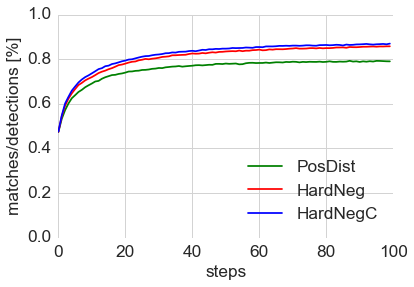

In [16]:
#All images and descs, loss comparison, Figure 2, top, in paper
%matplotlib inline
import cPickle as pickle

out_dir = 'figs_loss_comparison'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

results= pickle.load(open('all_results_ideal_joint2.pickle', 'rb'))

dn = '/home/old-ufo/Dropbox/HP/'
colors = ['g', 'r','b','m']
idx = 0
import matplotlib.pylab as pylab
params = {'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
shape_diffs = {}
losses = {}
SNN_th = 1.0
ELL_TH = 6.0
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgray'
dir1 = 'total'
for i in range(len(desc_names)):
    descn = desc_names[i]
    print descn
    plt.close('all')
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    leg = []
    for loss_idx in range(len(loss_names)):
        ln = loss_names[loss_idx]
        lf = loss_fns[loss_idx]
        c = colors[loss_idx]
        print ln
        try:
            ax2.plot(np.concatenate(results['MSE'][descn][ln]).mean(axis = 0),color = c, linestyle = '-')
            ax1.plot(np.concatenate(results['ells'][descn][ln]).mean(axis = 0),color = c, linestyle = '-.')
        except:
            ln = 'HardNetDetach'
            ax2.plot(np.concatenate(results['MSE'][descn][ln]).mean(axis = 0),color = c, linestyle = '-')
            ax1.plot(np.concatenate(results['ells'][descn][ln]).mean(axis = 0),color = c, linestyle = '-.')
        if ln == 'HardNet' or ln == 'HardNeg':
            leg.append('HardNeg')
        if ln == 'HardNetDetach' or  ln == 'HardNegC':
            leg.append('HardNegC')
        if ln == 'PosDist':
            leg.append('PosDist')
    ax2.legend(leg, loc='lower right', fontsize= 'xx-large')
    ax2.set_xlabel('steps')
    ax2.set_ylabel('Affine matrix MSE, solid')
    ax2.set_ylim([0,3.0])
    ax1.set_ylabel('Survived ellipses [%], dash-dot')
    ax1.set_ylim([0,1])
    fig.set_facecolor((1, 1, 1))
    fig_fn =  dir1 + descn +'_geoms_ideal_joint_snn1.eps'
    fig.savefig(os.path.join(out_dir,fig_fn),
                bbox_inches = 'tight', pad_inches = 0)
    leg = []
    plt.close('all')
    fig, ax1 = plt.subplots()
    for loss_idx in range(len(loss_names)):
        c = colors[loss_idx]
        ln = loss_names[loss_idx]
        lf = loss_fns[loss_idx]
        if ln == 'HardNet' or ln == 'HardNeg':
            leg.append('HardNeg')
        if ln == 'HardNetDetach' or  ln == 'HardNegC':
            leg.append('HardNegC')
        if ln == 'PosDist':
            leg.append('PosDist')
        try:
            ax1.plot(np.concatenate(results['match'][descn][ln]).mean(axis = 0), color = c, linestyle = '-')
        except:
            ln = 'HardNetDetach'
            ax1.plot(np.concatenate(results['match'][descn][ln]).mean(axis = 0), color = c, linestyle = '-')
    ax1.legend(leg, loc='lower right', fontsize= 'xx-large')
    ax1.set_ylim([0,1])
    ax1.set_xlabel('steps')
    ax1.set_ylabel('matches/detections [%]')
    fig.set_facecolor((1, 1, 1))
    fig_fn =  dir1 + descn +'_matches_ideal_joint_snn1.eps'
    fig.savefig(os.path.join(out_dir,fig_fn),
                bbox_inches = 'tight', pad_inches = 0)
    idx +=1
    #break

In [ ]:
#Video
import cPickle as pickle
dn = '/home/old-ufo/Dropbox/HP/'
colors = ['r','g','b','m']
idx = 0
for dir1 in sorted(os.listdir(dn)):
    if 'i_in' not in dir1:
        continue
    print dir1
    for loss_idx in range(len(loss_names)):
        ln = loss_names[loss_idx]
        print ln
        lf = loss_fns[loss_idx]
        LOP = LAFDiscrOptimDetach(desc_list, desc_names, cuda = True, lr = 1.0, loss_fn = lf, loss_name = ln)
        try:
            LOP.load_data(dir1 + '.pickle');
        except:
            break
        img1 = load_grayscale_var(os.path.join(dn,dir1) + '/1.ppm')
        LOP.img1 = img1.data.cpu().numpy()
        LOP.savemp4_per_desc(dir1 + '_ideal_joint.mp4')  